Usage:
* Choose labels to summarize
* Choose data to load
* Run everything

In [1]:
#%matplotlib notebook

In [ ]:
# --- third-party ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tabulate

# --- own ---
from datatools import MeasurementDataReader, MeasurementSeries, Measurement, DataTypes, to_ts_data
from datatools import ACC, GYR, MAG
from fhgutils import contextual_recarray_dtype

In [2]:

"""
# TORQUEWRENCH
summary_labels = {
    0: [0, 1, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],  # rest
#
#     1: tightening_pre, 
#     2: tightening_click, 
#     3: tightening_inter
#     4: tightening_clack
    1: [2, 3, 4]  
}

"""

# RIVETER
summary_labels = {
    # positioning, shaking, transport_by_hand, change_nose_piece, idle, undefined
    0: [7, 8, 9, 10, 11, 12],

    # 0: pull_trigger,
    # 1: hold_trigger,
    # 2: release_trigger
    # 3: pull_trigger_not_removed,
    # 4: pull_trigger_air,
    # 5: pull_trigger_with_rivet
    # 6: pull_trigger_air_with_rivet_not_removed
    1: [0, 1, 2, 3, 4, 5, 6],

    # 2: [2] # 2: release_trigger
}

summary_labels = None


# Load all data
mdr = MeasurementDataReader(source="tool-tracking-data")
data = mdr.query().filter_by(
    MeasurementSeries == ['pythagoras-03-20190902', 'pythagoras-04-20190903', 'pythagoras-04-20190905', 'pythagoras-05-20190905', 'pythagoras-06-20190905'],  # RIVETER
    DataTypes == [ACC, GYR, MAG]
).get()

Xt, Xc, y = to_ts_data(data, contextual_recarray_dtype)

[INFO] Read annotation: 100%|██████████| 3/3 [00:00<00:00, 80.24it/s, file=data-01.annotation]

[INFO] Checking if master is up to date ...
[INFO] The datatools (v0.5.1) package is set up correctly
[INFO] Preparing measurements from:
  /Users/mut/workspace/lmudataset/pneumatic_riveting_gun/pythagoras-06-20190905
  /Users/mut/workspace/lmudataset/pneumatic_riveting_gun/pythagoras-04-20190903
  /Users/mut/workspace/lmudataset/pneumatic_riveting_gun/pythagoras-03-20190902
  /Users/mut/workspace/lmudataset/pneumatic_riveting_gun/pythagoras-04-20190905
  /Users/mut/workspace/lmudataset/pneumatic_riveting_gun/pythagoras-05-20190905
[INFO] Skipping mf data (not selected).
[INFO] Skipping audio data (not selected).
[INFO] Skipping audio data (not selected).
[INFO] Skipping mf data (not selected).


[INFO] Read annotation: 100%|██████████| 6/6 [00:00<00:00, 81.01it/s, file=data-02.annotation] 


[INFO] Skipping mf data (not selected).
[INFO] Skipping audio data (not selected).
[INFO] Skipping audio data (not selected).
[INFO] Skipping mf data (not selected).
[INFO] Skipping audio data (not selected).
[INFO] Skipping mf data (not selected).
[INFO] Skipping mf data (not selected).
[INFO] Skipping audio data (not selected).
[INFO] Finished with 6 measurement(s).


In [3]:
# summarize labels
if summary_labels is not None:
    for i in range(len(y)):
        y_summarized = np.array(y[i], copy=True)
        for key, labels in summary_labels.items():
            for label in labels:
                # Mask y based on the values of the original array
                mask = np.ma.masked_equal(y[i], label)
                y_summarized[mask.mask] = key
        print(f"[INFO] Summarized labels from {np.unique(y[i])} to {np.unique(y_summarized)}")
        y[i] = y_summarized
    


duration_arr = None
for i in range(len(Xt)):
    # For each measurement, calculate the duration of each window
    data = np.array(Xt[i])
    t_diff = np.diff(data[:, 0])  # conversion from ms to s?
    t_diff = np.insert(t_diff, 0, 0)  # first diff is zero
    yt = np.array(y[i])

    # duration is the summed diffs of timestamps of consecutive, equal y's
    current_y = -1
    duration = 0
    for i in range(len(yt)):
        previous_y = current_y
        current_y = yt[i]
        if current_y == previous_y:
            duration += t_diff[i]
        else:  # add to our duration array
            if duration_arr is None:
                duration_arr = np.array([[current_y, duration]])
            else:
                duration_arr = np.append(duration_arr, np.array([[previous_y, duration]]), axis=0)
            duration = 0
            previous_y = current_y
duration_df = pd.DataFrame(duration_arr, columns=["y", "duration [s]"])

Text(0.5, 1, 'Overview')

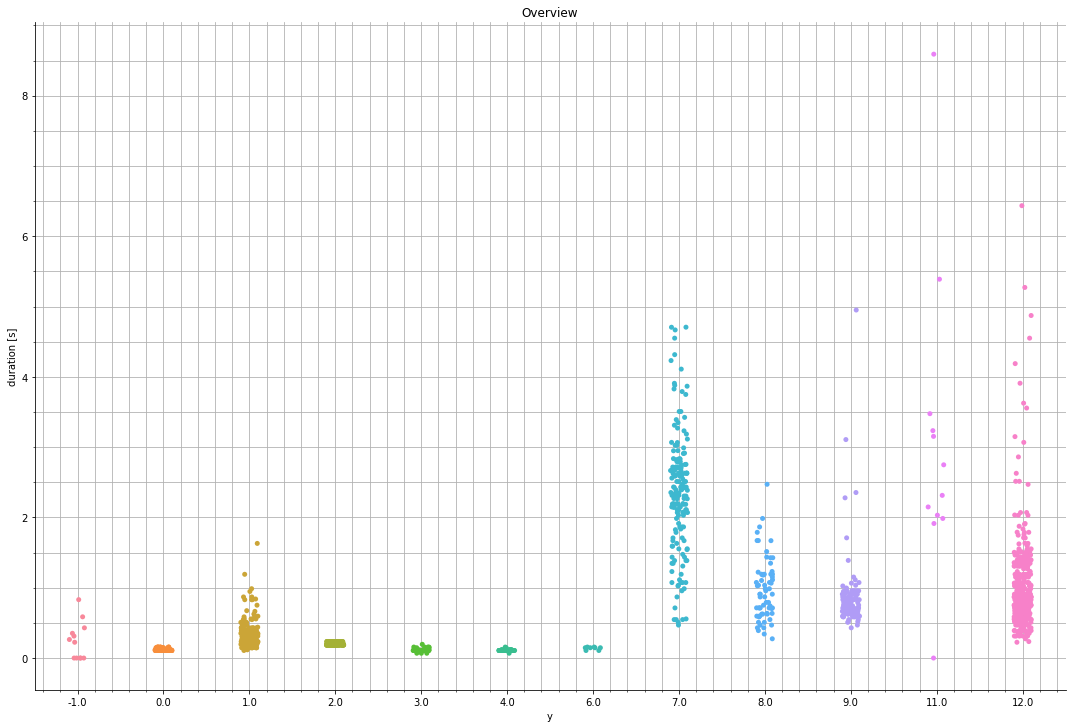

In [4]:
# Categorical scatterplot
sns.catplot(x="y", y="duration [s]", data=duration_df, height=10, aspect=1.5)
plt.minorticks_on()
plt.grid(b=True, which='both')
plt.title("Overview")



Overview:
  Label        Min       Max      Mean    Median        Std    90% Percentile    95% Percentile
-------  ---------  --------  --------  --------  ---------  ----------------  ----------------
     -1  0          0.830706  0.24994   0.24419   0.271394           0.5707            0.696327
      0  0.107393   0.156513  0.116399  0.107503  0.0150341          0.146474          0.156277
      1  0.107603   1.63074   0.336157  0.288276  0.193433           0.546824          0.708932
      2  0.185497   0.23477   0.202919  0.195298  0.0190798          0.234358          0.234394
      3  0.0683544  0.19526   0.115658  0.107414  0.0239989          0.152314          0.156239
      4  0.0683544  0.156208  0.111078  0.107503  0.0115138          0.117239          0.117358
      6  0.107393   0.156208  0.139123  0.146445  0.0200422          0.156208          0.156208
      7  0.468716   4.70669   2.35317   2.38683   0.854995           3.35722           3.87469
      8  0.273898   2.47179  

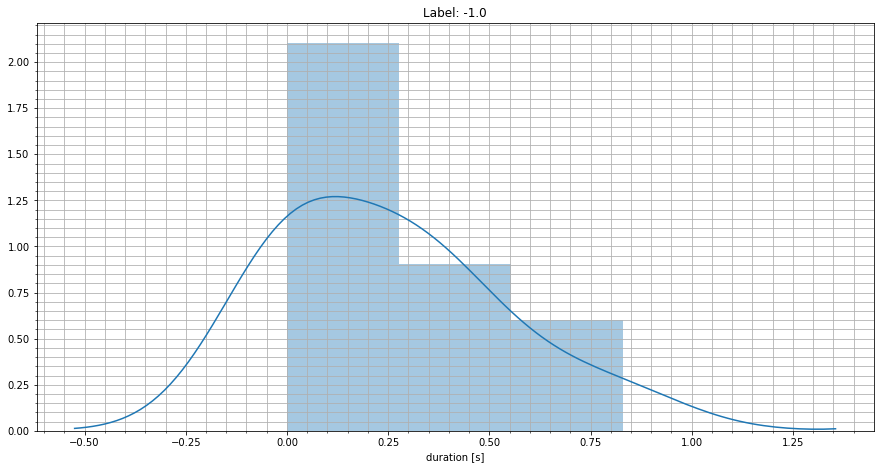

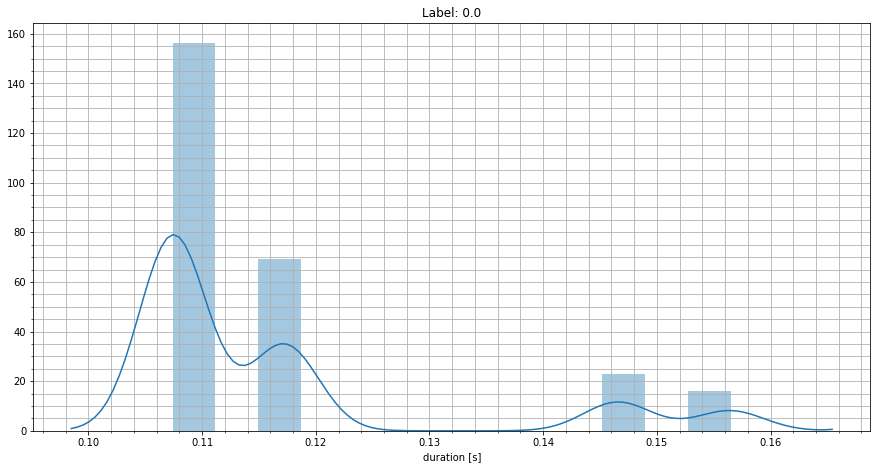

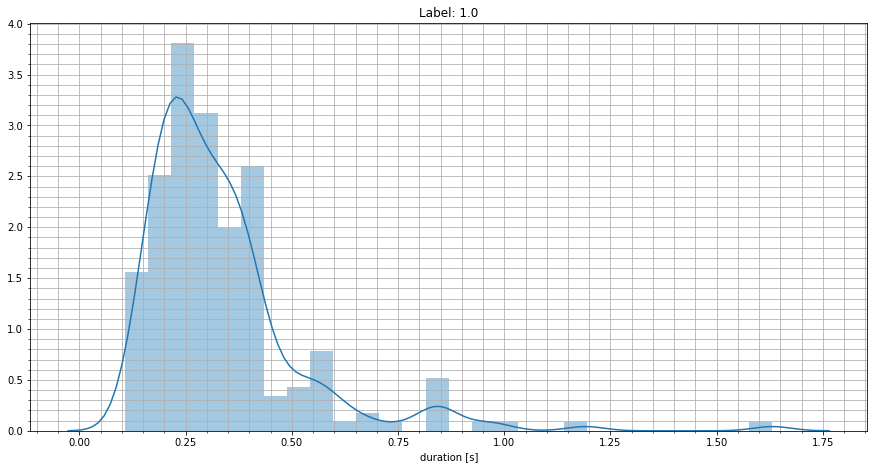

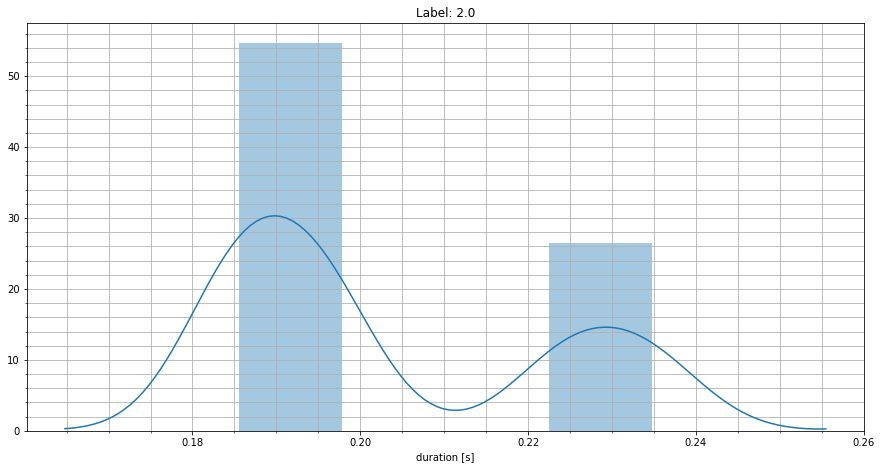

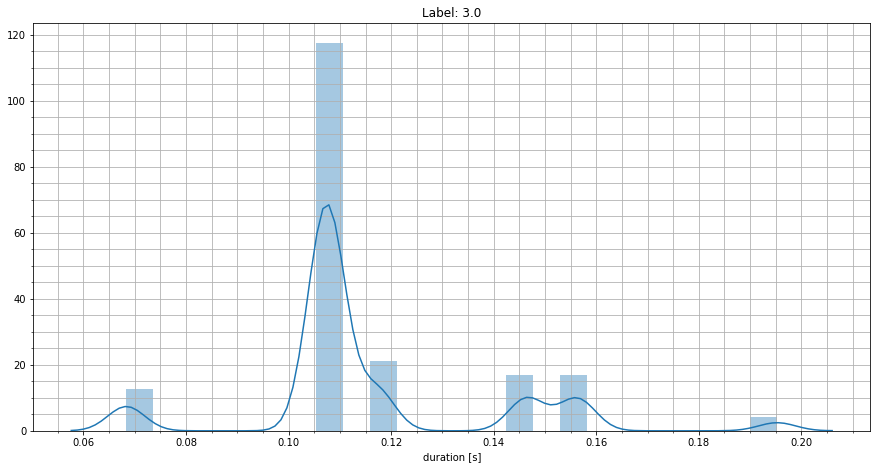

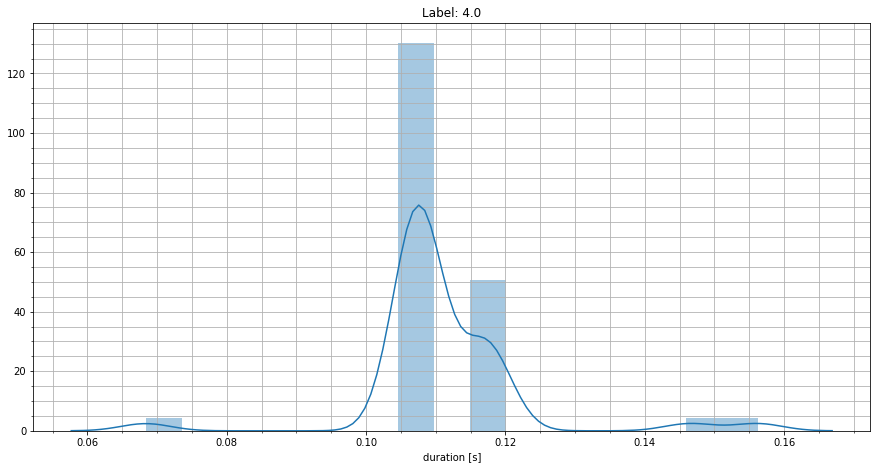

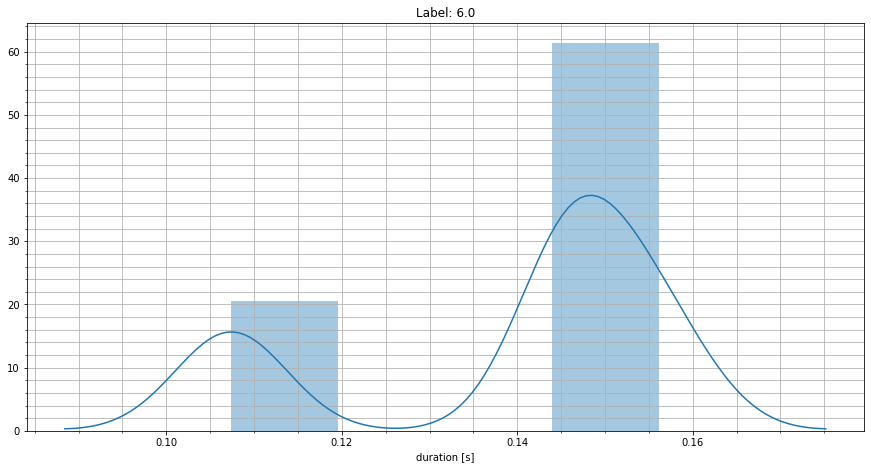

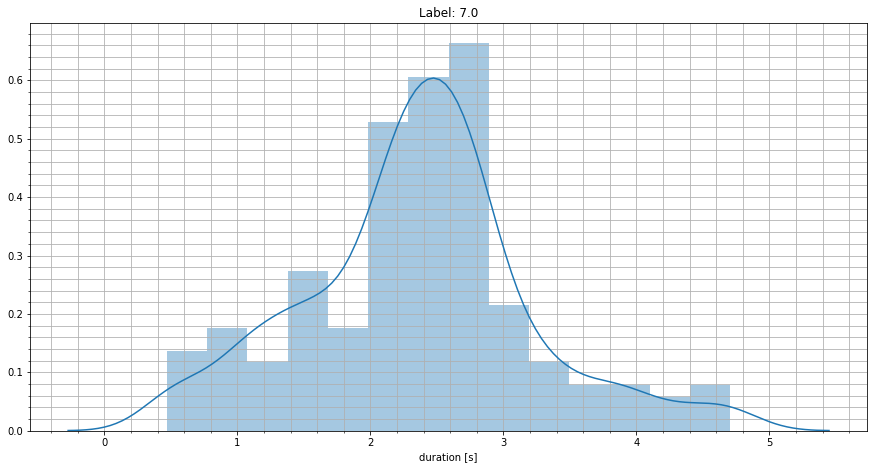

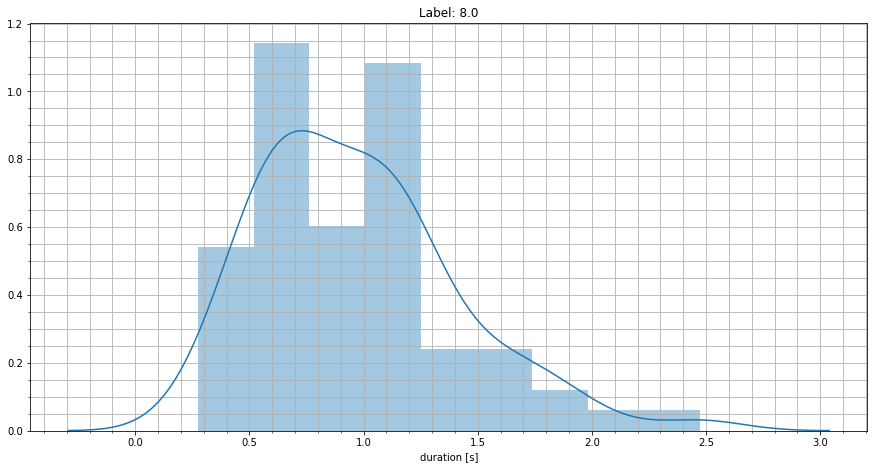

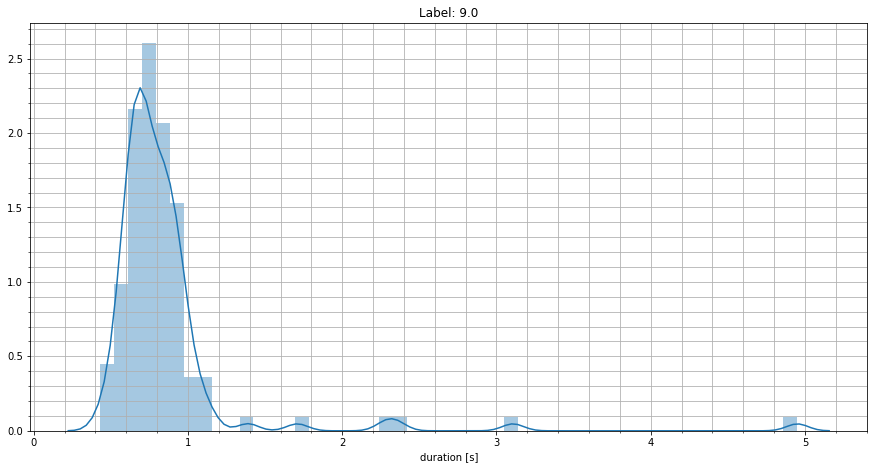

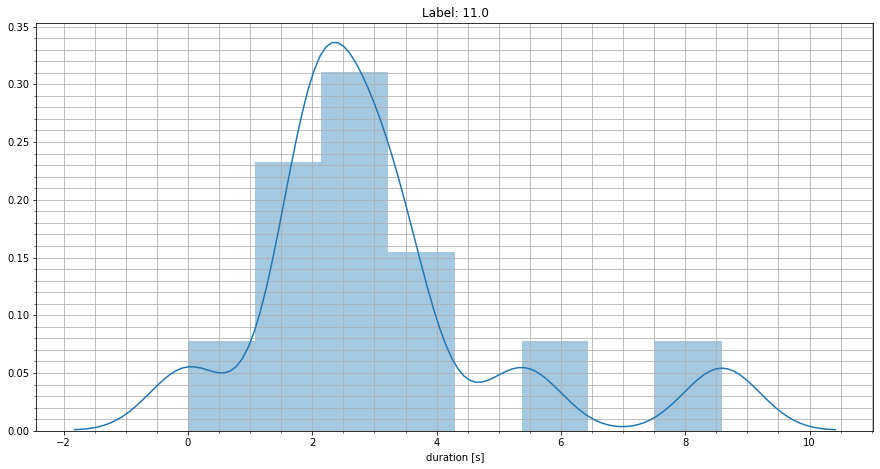

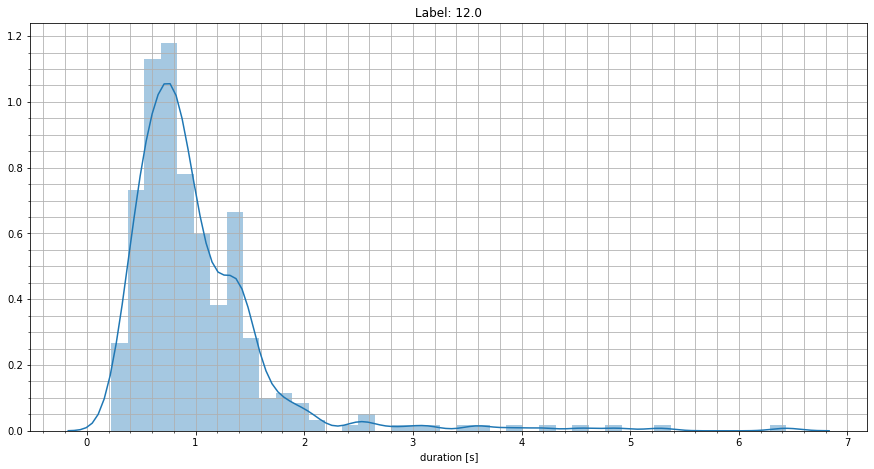

In [5]:
# Detailed single plots
table = []
print("\n\nOverview:")
for y_uniq in np.unique(duration_df.loc[:, "y"]):
    duration_df_uniq = duration_df.loc[duration_df.loc[:, "y"] == y_uniq, "duration [s]"]
    plt.figure(figsize=(15, 7.5))
    sns.distplot(duration_df_uniq)
    plt.title(f"Label: {y_uniq}")
    plt.minorticks_on()
    plt.grid(b=True, which='both')
    table += [[y_uniq, duration_df_uniq.min(),
               duration_df_uniq.max(),
               duration_df_uniq.mean(),
               duration_df_uniq.median(),
               duration_df_uniq.std(),
               duration_df_uniq.quantile(q=0.9),
               duration_df_uniq.quantile(q=0.95)]]
print(tabulate.tabulate(table, headers=["Label", "Min", "Max", "Mean", "Median", "Std", "90% Percentile", "95% Percentile"]))
plt.show()